In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

/Users/tupa/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/tupa/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/tupa/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is

In [2]:
A = pd.read_csv('../data/FEATURES_clean.csv',index_col='File')
X = A.copy()
y = np.array(X.Type).astype(int)
X.drop(columns={'Type','Subject'},inplace=True)

feature_names=X.columns.to_list()

In [3]:
# Feature Scaling
#sc = StandardScaler()
#Xs = sc.fit_transform(X)
# Data Balancing
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 0)

In [5]:
names = [ "Decision Tree",
         "Random Forest"]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier()]

params = [{'criterion' : ['gini', 'entropy'], # Decision tree
           'max_depth' : np.arange(1,20),
           'random_state' : [0]},   
          {'n_estimators' : list(range(1,21,10)),  # Random Forrest
           'max_features' : list(range(1,np.size(X,axis=1),5))}]

### GRID SEARCH FOR ALL CLASSIFIERS

In [6]:
best_params = [None]*len(classifiers)
for i,c in enumerate(classifiers):    
    # Create grid search object

    clf = GridSearchCV(c,param_grid = params[i],cv=5,iid=True)

    # Fit on data

    best_clf = clf.fit(X_train, y_train)
    
    best_params[i] = clf.best_params_
    
    

In [7]:
best_params

[{'criterion': 'gini', 'max_depth': 2, 'random_state': 0},
 {'max_features': 31, 'n_estimators': 11}]

### FEATURE IMPORTANCE
### FOR DECISION TREE AND RANDOM FOREST

In [8]:
M = len(X.columns.to_list())
dt = np.empty((M,1))
rf = np.empty((M,1))

for name, clf, param in zip(names, classifiers, best_params):
    if name == 'Decision Tree':
        #print(name)
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        dt_clf= clf
        dt_fi = clf.feature_importances_
    if name == 'Random Forest':
        #print(name)
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        rf_clf = clf
        rf_fi = clf.feature_importances_


In [9]:
def plot_feat_importance(tree_feature_importances,feature_names,clf_name,ax):
    Z = [x for _,x in sorted(zip(tree_feature_importances,feature_names))]
    sorted_idx = tree_feature_importances.argsort()
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, tree_feature_importances[sorted_idx])
    ax.set_yticklabels(Z)
    ax.set_yticks(y_ticks)
    ax.set_title("FEATURE IMPORTANCE \n " + clf_name, fontsize = 20)

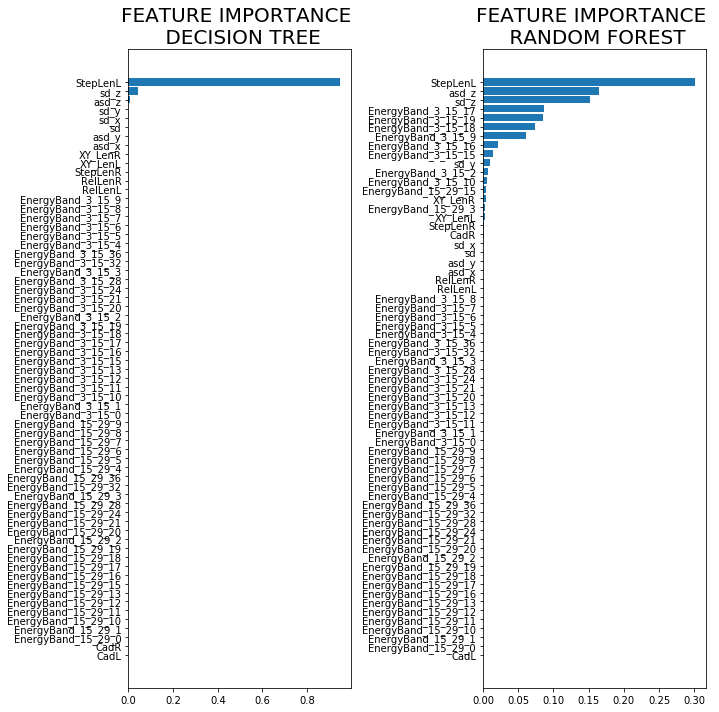

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,10))

plot_feat_importance(dt_fi,feature_names,'DECISION TREE',ax1)
plot_feat_importance(rf_fi,feature_names,'RANDOM FOREST',ax2)

fig.tight_layout()
#plt.show()

plt.savefig('../Figures/Results/FI.eps', format='eps',dpi=300, bbox_inches = 'tight')
plt.savefig('../Figures/Results/FI.png',dpi=300, bbox_inches = 'tight')

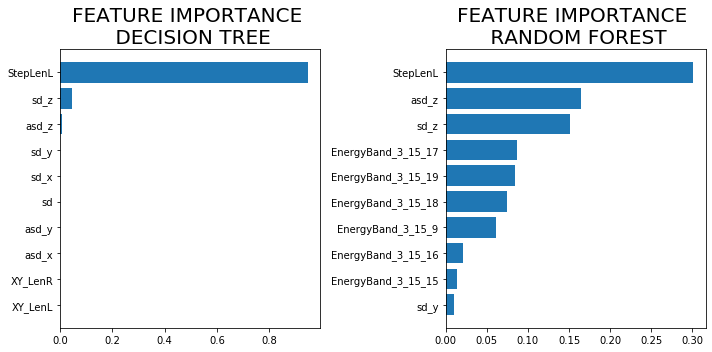

In [11]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5))

# TOP 10 ONLY 
N=10
cut_fi=np.sort(dt_fi)[-N:]
cut_names = [x for _,x in sorted(zip(dt_fi,feature_names))][-N:]

plot_feat_importance(cut_fi,cut_names,'DECISION TREE',ax1)

cut_fi=np.sort(rf_fi)[-N:]
cut_names = [x for _,x in sorted(zip(rf_fi,feature_names))][-N:]

plot_feat_importance(cut_fi,cut_names,'RANDOM FOREST',ax2)

fig.tight_layout()
#plt.show()

plt.savefig('../Figures/Results/FI_10.eps', format='eps',dpi=300, bbox_inches = 'tight')
plt.savefig('../Figures/Results/FI_10.png',dpi=300, bbox_inches = 'tight')

### permutation_importance

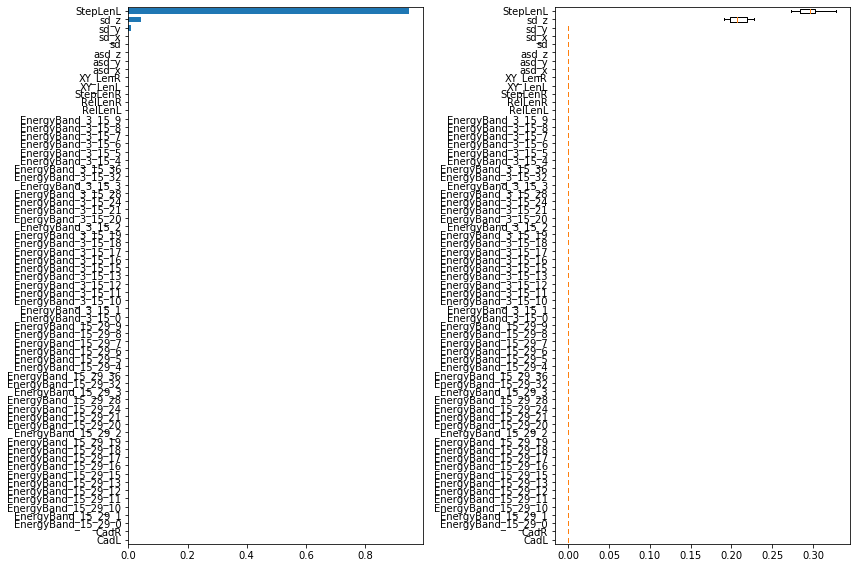

In [12]:
clf = dt_clf
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
Z = [x for _,x in sorted(zip(result.importances_mean,feature_names))]

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(Z)
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=Z)
fig.tight_layout()
plt.show()

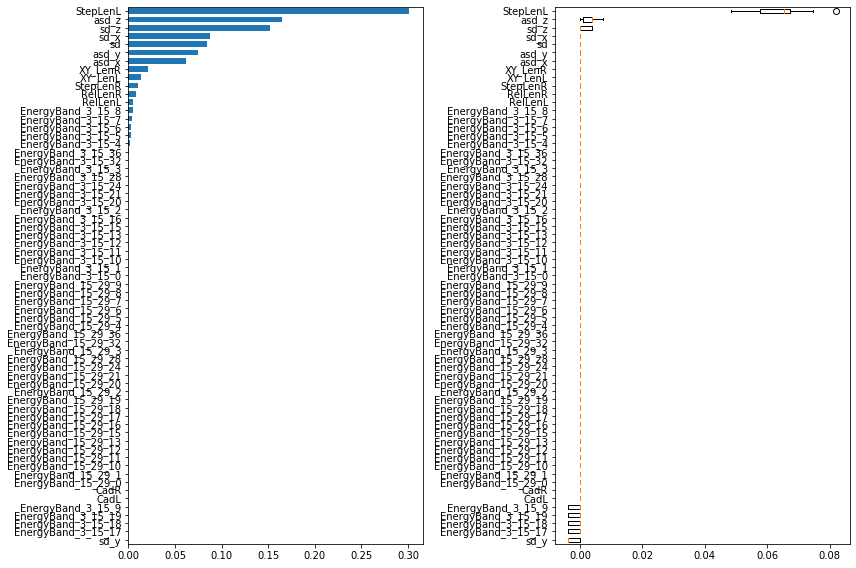

In [13]:
clf = rf_clf
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
Z = [x for _,x in sorted(zip(result.importances_mean,feature_names))]

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(Z)
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=Z)
fig.tight_layout()
plt.show()

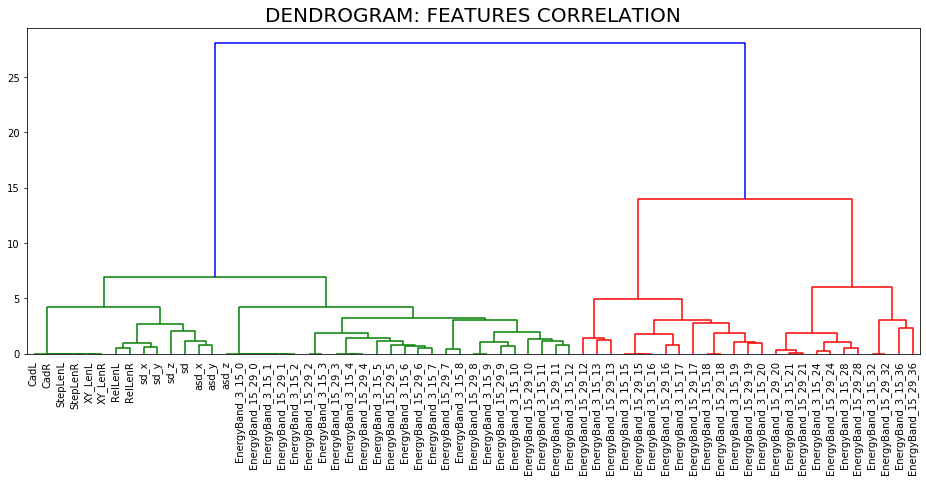

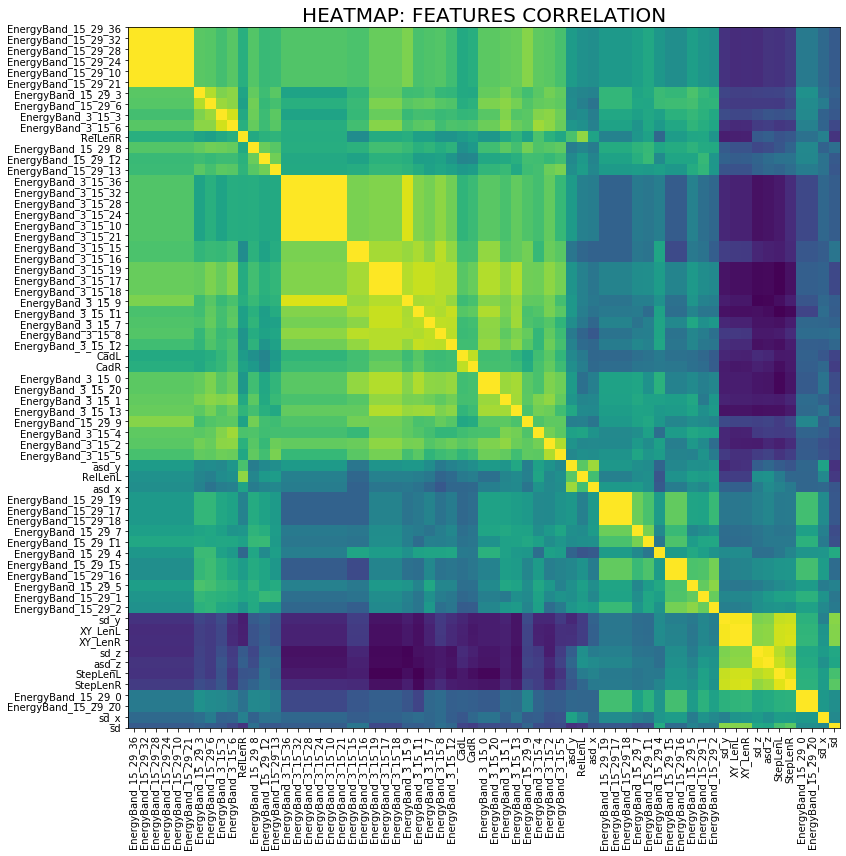

In [20]:
fig,ax1 = plt.subplots(figsize=(16, 6))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=feature_names, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax1.set_xticklabels(feature_names,fontsize=10)
ax1.set_title('DENDROGRAM: FEATURES CORRELATION',fontsize=20)

plt.savefig('../Figures/Results/Feat_corrDendro.eps', format='eps', bbox_inches = 'tight')
plt.savefig('../Figures/Results/Feat_corrDendro.png', bbox_inches = 'tight')

fig,ax2 = plt.subplots(figsize=(12, 12))
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical',fontsize=10)
ax2.set_yticklabels(dendro['ivl'],fontsize=10)
ax2.set_title('HEATMAP: FEATURES CORRELATION',fontsize=20)

fig.tight_layout()

plt.savefig('../Figures/Results/Feat_corr.eps', format='eps', bbox_inches = 'tight')
plt.savefig('../Figures/Results/Feat_corr.png', bbox_inches = 'tight')

plt.show()

In [21]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 1.00


In [22]:
fnames = np.array(feature_names)
for i in cluster_id_to_feature_ids:
    print(i)
    print(fnames[cluster_id_to_feature_ids[i]])

11
['CadL' 'CadR']
28
['StepLenL' 'StepLenR']
26
['XY_LenL' 'XY_LenR' 'sd_y']
17
['RelLenL']
5
['RelLenR']
30
['sd_x']
27
['sd_z' 'asd_z']
31
['sd']
18
['asd_x']
19
['asd_y']
12
['EnergyBand_3_15_0' 'EnergyBand_3_15_20']
29
['EnergyBand_15_29_0' 'EnergyBand_15_29_20']
13
['EnergyBand_3_15_1' 'EnergyBand_3_15_13']
23
['EnergyBand_15_29_1' 'EnergyBand_15_29_2']
14
['EnergyBand_3_15_2' 'EnergyBand_3_15_5']
2
['EnergyBand_3_15_3' 'EnergyBand_15_29_3' 'EnergyBand_3_15_6'
 'EnergyBand_15_29_6']
15
['EnergyBand_3_15_4']
25
['EnergyBand_15_29_4']
24
['EnergyBand_15_29_5']
9
['EnergyBand_3_15_7' 'EnergyBand_3_15_8' 'EnergyBand_3_15_11'
 'EnergyBand_3_15_12']
21
['EnergyBand_15_29_7' 'EnergyBand_15_29_11']
4
['EnergyBand_15_29_8']
10
['EnergyBand_3_15_9']
16
['EnergyBand_15_29_9']
6
['EnergyBand_3_15_10' 'EnergyBand_3_15_21' 'EnergyBand_3_15_24'
 'EnergyBand_3_15_28' 'EnergyBand_3_15_32' 'EnergyBand_3_15_36']
1
['EnergyBand_15_29_10' 'EnergyBand_15_29_21' 'EnergyBand_15_29_24'
 'EnergyBand_15_29

In [23]:
np.array(feature_names)[selected_features]

array(['CadL', 'StepLenL', 'XY_LenL', 'RelLenL', 'RelLenR', 'sd_x',
       'sd_z', 'sd', 'asd_x', 'asd_y', 'EnergyBand_3_15_0',
       'EnergyBand_15_29_0', 'EnergyBand_3_15_1', 'EnergyBand_15_29_1',
       'EnergyBand_3_15_2', 'EnergyBand_3_15_3', 'EnergyBand_3_15_4',
       'EnergyBand_15_29_4', 'EnergyBand_15_29_5', 'EnergyBand_3_15_7',
       'EnergyBand_15_29_7', 'EnergyBand_15_29_8', 'EnergyBand_3_15_9',
       'EnergyBand_15_29_9', 'EnergyBand_3_15_10', 'EnergyBand_15_29_10',
       'EnergyBand_15_29_12', 'EnergyBand_3_15_15', 'EnergyBand_15_29_15',
       'EnergyBand_3_15_17', 'EnergyBand_15_29_17'], dtype='<U19')

## ENERGY BANDS ONLY

In [24]:
not_ene_cols=[];ene_cols=[]
for feat in X.columns.to_list():
    if not feat.startswith('EnergyBand'):
        not_ene_cols.append(feat)
    else:
        ene_cols.append(feat) 

#### APEND JOINT NAME TO THE ENERGY BAND JOINT NUMBER

In [25]:
text_file = open('../data/JointNames.txt', "r")
joint_names_calc = text_file.read().split('\n')
parse=pd.DataFrame(data=joint_names_calc,columns={'PositionNames'})
parse['Num']=parse.index
eneBands_names=pd.DataFrame(data=ene_cols,columns={'EneBands'})
for s in eneBands_names.EneBands: eneBands_names.loc[eneBands_names.EneBands==s,'Num'] = int(s.split('_')[-1])
result = pd.merge(eneBands_names, parse, on='Num')
result['Ene_Names']=result.EneBands+'_'+result.PositionNames

In [26]:
X = A[ene_cols].copy()
feature_names = np.array(result['Ene_Names'])

# Feature Scaling
#sc = StandardScaler()
#Xs = sc.fit_transform(X)
# Data Balancing
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 0)

In [27]:
best_params = [None]*len(classifiers)
for i,c in enumerate(classifiers):    
    # Create grid search object

    clf = GridSearchCV(c,param_grid = params[i],cv=10,iid=True)

    # Fit on data

    best_clf = clf.fit(X_train, y_train)
    
    best_params[i] = clf.best_params_

In [28]:
M = len(X.columns.to_list())
dt = np.empty((M,1))
rf = np.empty((M,1))
#feature_names=np.array(X.columns.to_list())

for name, clf, param in zip(names, classifiers, best_params):
    if name == 'Decision Tree':
        print(name)
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        dt_clf= clf
        dt_fi = clf.feature_importances_
    if name == 'Random Forest':
        print(name)
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        rf_clf = clf
        rf_fi = clf.feature_importances_

Decision Tree
Random Forest


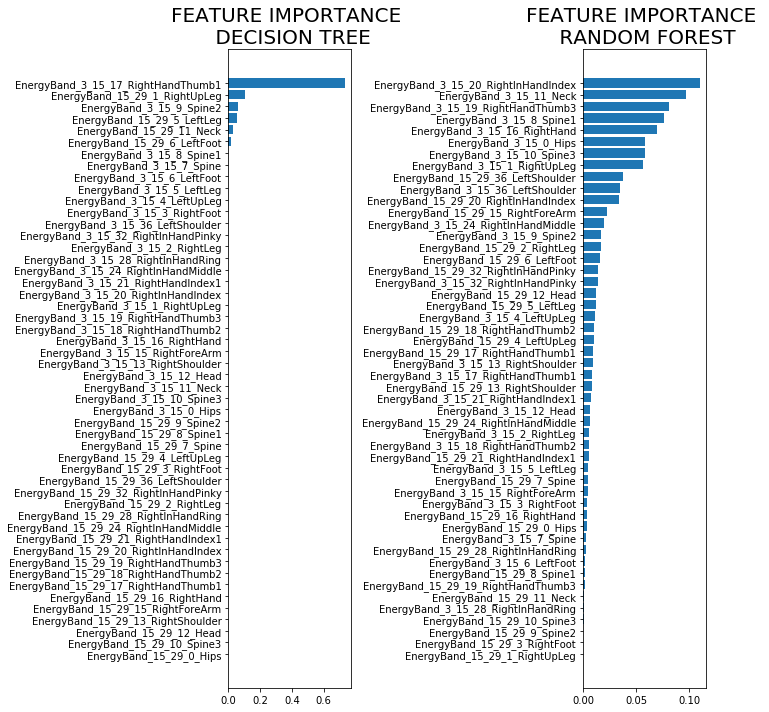

In [29]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,10))

plot_feat_importance(dt_fi,feature_names,'DECISION TREE',ax1)
plot_feat_importance(rf_fi,feature_names,'RANDOM FOREST',ax2)

fig.tight_layout()
#plt.show()

plt.savefig('../Figures/Results/ENE_FI.eps', format='eps',dpi=300, bbox_inches = 'tight')
plt.savefig('../Figures/Results/ENE_FI.png',dpi=300, bbox_inches = 'tight')

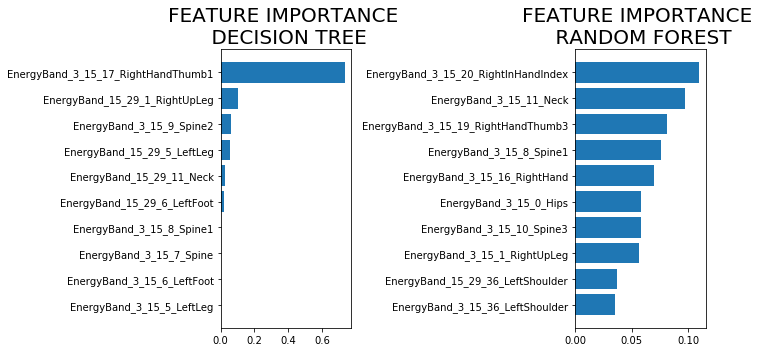

In [30]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,5))

# TOP 10 ONLY 
N=10
cut_fi=np.sort(dt_fi)[-N:]
cut_names = [x for _,x in sorted(zip(dt_fi,feature_names))][-N:]

plot_feat_importance(cut_fi,cut_names,'DECISION TREE',ax1)

cut_fi=np.sort(rf_fi)[-N:]
cut_names = [x for _,x in sorted(zip(rf_fi,feature_names))][-N:]

plot_feat_importance(cut_fi,cut_names,'RANDOM FOREST',ax2)

fig.tight_layout()
#plt.show()

plt.savefig('../Figures/Results/ENE_FI_10.eps', format='eps',dpi=300, bbox_inches = 'tight')
plt.savefig('../Figures/Results/ENE_FI_10.png',dpi=300, bbox_inches = 'tight')

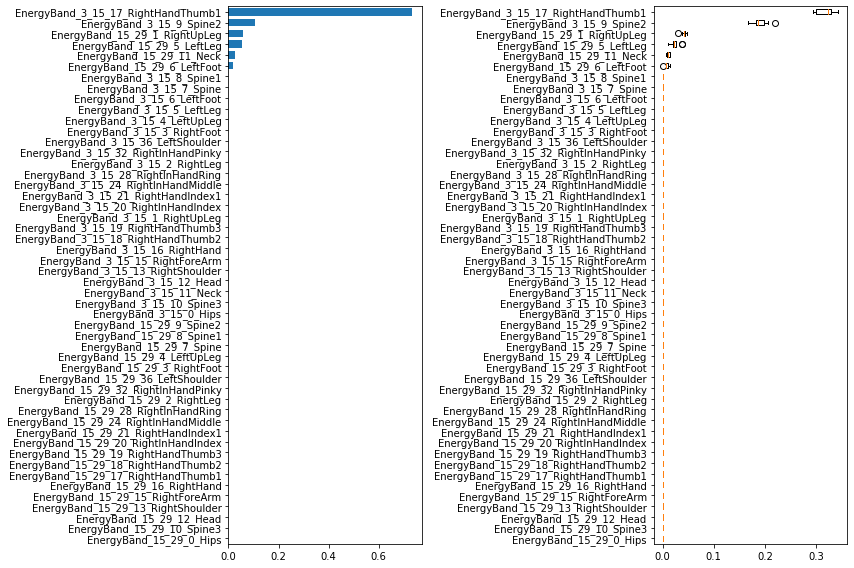

In [31]:
clf = dt_clf
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
Z = [x for _,x in sorted(zip(result.importances_mean,feature_names))]

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(Z)
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=Z)
fig.tight_layout()
plt.show()

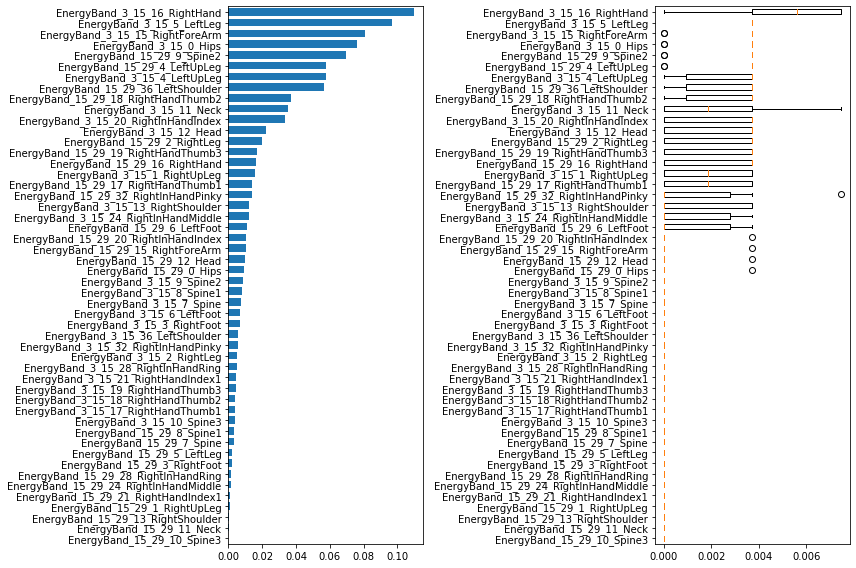

In [32]:
clf = rf_clf
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()
Z = [x for _,x in sorted(zip(result.importances_mean,feature_names))]

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(Z)
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=Z)
fig.tight_layout()
plt.show()

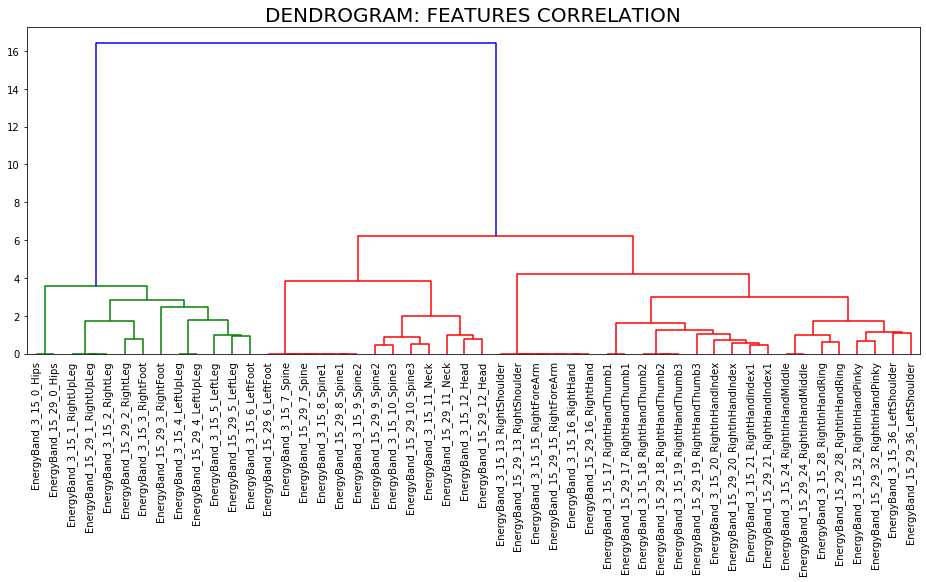

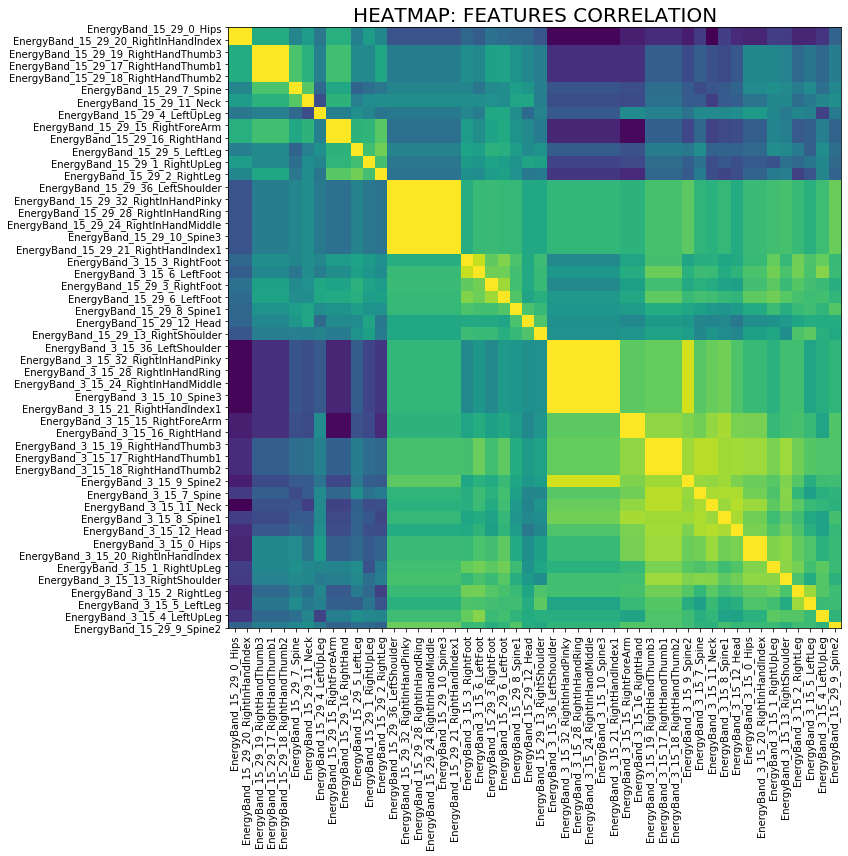

In [33]:
fig,ax1 = plt.subplots(figsize=(16, 6))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=feature_names, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax1.set_xticklabels(feature_names,fontsize=10)
ax1.set_title('DENDROGRAM: FEATURES CORRELATION',fontsize=20)

plt.savefig('../Figures/Results/ENE_FeatCorrDendro.eps', format='eps', bbox_inches = 'tight')
plt.savefig('../Figures/Results/ENE_FeatCorrDendro.png', bbox_inches = 'tight')

fig,ax2 = plt.subplots(figsize=(12, 12))
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical',fontsize=10)
ax2.set_yticklabels(dendro['ivl'],fontsize=10)
ax2.set_title('HEATMAP: FEATURES CORRELATION',fontsize=20)
fig.tight_layout()
#plt.show()

plt.savefig('../Figures/Results/ENE_FeatCorr.eps', format='eps', bbox_inches = 'tight')
plt.savefig('../Figures/Results/ENE_FeatCorr.png', bbox_inches = 'tight')

In [34]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 1.00


In [35]:
fnames = np.array(feature_names)
for i in cluster_id_to_feature_ids:
    print(i)
    print(fnames[cluster_id_to_feature_ids[i]])

15
['EnergyBand_3_15_0_Hips' 'EnergyBand_3_15_1_RightUpLeg'
 'EnergyBand_3_15_13_RightShoulder' 'EnergyBand_3_15_20_RightInHandIndex']
1
['EnergyBand_15_29_0_Hips' 'EnergyBand_15_29_20_RightInHandIndex']
5
['EnergyBand_15_29_1_RightUpLeg' 'EnergyBand_15_29_2_RightLeg'
 'EnergyBand_15_29_5_LeftLeg']
16
['EnergyBand_3_15_2_RightLeg' 'EnergyBand_3_15_5_LeftLeg']
8
['EnergyBand_3_15_3_RightFoot' 'EnergyBand_15_29_3_RightFoot'
 'EnergyBand_3_15_6_LeftFoot' 'EnergyBand_15_29_6_LeftFoot']
17
['EnergyBand_3_15_4_LeftUpLeg']
6
['EnergyBand_15_29_4_LeftUpLeg']
13
['EnergyBand_3_15_7_Spine' 'EnergyBand_3_15_8_Spine1'
 'EnergyBand_3_15_11_Neck' 'EnergyBand_3_15_12_Head']
3
['EnergyBand_15_29_7_Spine' 'EnergyBand_15_29_11_Neck']
9
['EnergyBand_15_29_8_Spine1' 'EnergyBand_15_29_12_Head'
 'EnergyBand_15_29_13_RightShoulder']
14
['EnergyBand_3_15_9_Spine2']
18
['EnergyBand_15_29_9_Spine2']
10
['EnergyBand_3_15_10_Spine3' 'EnergyBand_3_15_21_RightHandIndex1'
 'EnergyBand_3_15_24_RightInHandMiddle'
 'En